In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
####################################### Set Axes
def set_axes(ax_list, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
    for ax in ax_list:
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
####################################### Plotting Function
def set_label(ax, xpcent, ypcent, text, fontsize=12, color='k'):
    
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x2 = xpcent/100.
    x1 = 1.-x2
    y2 = ypcent/100.
    y1 = 1.-y2
    x0 = x1*Xlm[0]+x2*Xlm[1]
    y0 = y1*Ylm[0]+y2*Ylm[1]
    ax.text(x0,y0, text, fontsize=fontsize, color=color)



In [3]:
## Luminosity function parameters
alpha = -1
Ms = -22

## TF realtion parameters
zp = -20.85
slope = -8.37

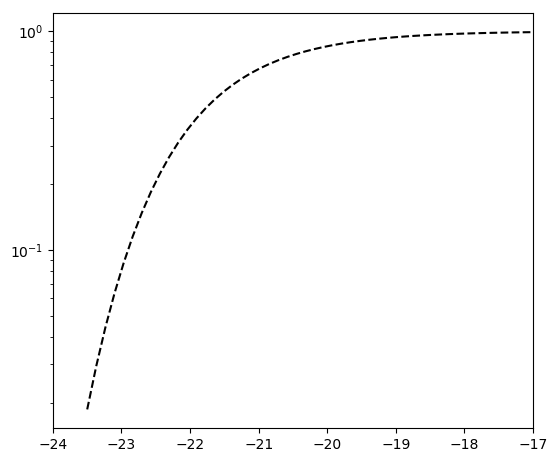

In [4]:
fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)
ax.set_xlim([-24,-17])

M = np.linspace(-23.5,-17,50)
N = LFfunction(M, Ms, alpha)
ax.plot(M,N,'k--')

ax.set_yscale("log", nonposy='clip')

0.48810635216622034


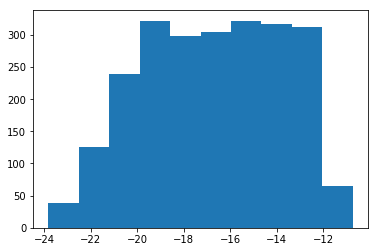

In [5]:
np.random.seed(0)

size = 3000
randMGAG = np.random.uniform(low=-24, high=-12, size=size)

randU = np.random.uniform(low=0, high=1, size=size)

randLfunct = LFfunction(randMGAG, Ms, alpha)

indx, = np.where(randU<randLfunct)

simulMag  = randMGAG[indx]
simulWimx = (simulMag-zp)/slope + 2.5
N = len(simulMag)
scatterMAG = np.random.normal(0, 0.49, N)
simulMag += scatterMAG


# print randMGAG
# print randU
plt.hist(simulMag)
print np.std(scatterMAG)

0.47223520725407975


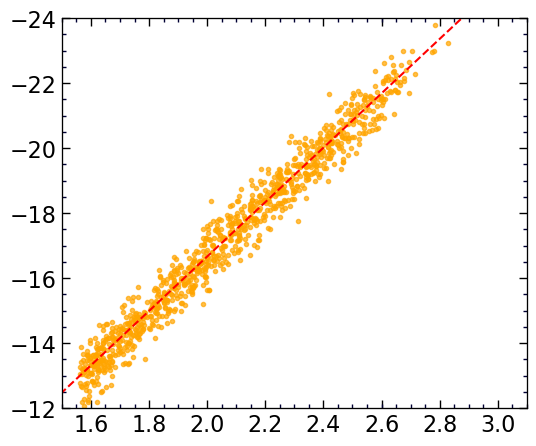

In [6]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

set_axes([ax], [1.5,3.1], [-12,-24])

x = np.linspace(-5,5,50)
y = slope*(x-2.5)+zp
 
    
bias, simulMag, simulWimx = simulFiled_Mscatter(slope, zp, Ms, alpha, 
               mag_scatter=0.49, size=1000, seed=0)
ax.plot(simulWimx, simulMag, '.', color='orange', alpha=0.7)
print np.std(simulMag-(slope*(simulWimx-2.5)+zp))


# bias, simulMag, simulWimx = simulFiled_Wscatter(slope, zp, Ms, alpha, 
#                mag_scatter=0.4, size=150, seed=0)
# ax.plot(simulWimx, simulMag, '.', color='green', alpha=0.7)
# print np.std(simulMag-(slope*(simulWimx-2.5)+zp))



# bias, simulMag, simulWimx, real_mag, reallWimx  = simulFiled_MWscatter(slope, zp, Ms, alpha, 
#                mag_scatter=0.4, size=150, seed=0)
# ax.plot(simulWimx, simulMag, '.', color='red', alpha=0.7)
# print np.std(simulMag-(slope*(simulWimx-2.5)+zp))



ax.plot(x,y, 'r--') 


In [7]:
n_simul = 50
d_mag = 0.05
mag_scatter = 0.4

#########################################################


M0 = np.arange(-16,-24,-0.5)
n_mag = len(M0)
outputs = np.zeros(n_mag*n_simul)
outputs = outputs.reshape(n_simul, n_mag)
for i in range(n_simul):
    bias, simulMag, simulWimx = simulFiled_Mscatter(slope, zp, Ms, alpha, 
               mag_scatter=mag_scatter, size=100000, seed=i)
    outputs[i] = simulFiled_ensemble(M0, slope, zp, bias, simulMag, simulWimx, d_mag=d_mag, dW=None)
    if i%10==0:
        print i
biasM = np.median(outputs, 0)
bias_errM = np.std(outputs, 0)


#########################################################


M0 = np.arange(-16,-24,-0.5)
n_mag = len(M0)
outputs = np.zeros(n_mag*n_simul)
outputs = outputs.reshape(n_simul, n_mag)
for i in range(n_simul):
    bias, simulMag, simulWimx = simulFiled_Wscatter(slope, zp, Ms, alpha, 
               mag_scatter=mag_scatter, size=100000, seed=i)
    outputs[i] = simulFiled_ensemble(M0, slope, zp, bias, simulMag, simulWimx, d_mag=d_mag, dW=None)
    if i%10==0:
        print i
biasW = np.median(outputs, 0)
bias_errW = np.std(outputs, 0)
#########################################################


M0 = np.arange(-16,-24,-0.5)
n_mag = len(M0)
outputs = np.zeros(n_mag*n_simul)
outputs = outputs.reshape(n_simul, n_mag)
for i in range(n_simul):
    bias, simulMag, simulWimx, real_mag, reallWimx  = simulFiled_MWscatter(slope, zp, Ms, alpha, 
               mag_scatter=mag_scatter, size=100000, seed=i)
    outputs[i] = simulFiled_ensemble(M0, slope, zp, bias, simulMag, simulWimx, d_mag=d_mag, dW=None)
    if i%10==0:
        print i
biasMW = np.median(outputs, 0)
bias_errMW = np.std(outputs, 0)

0
10
20
30
40
0
10
20
30
40
0
10
20
30
40


<ErrorbarContainer object of 3 artists>

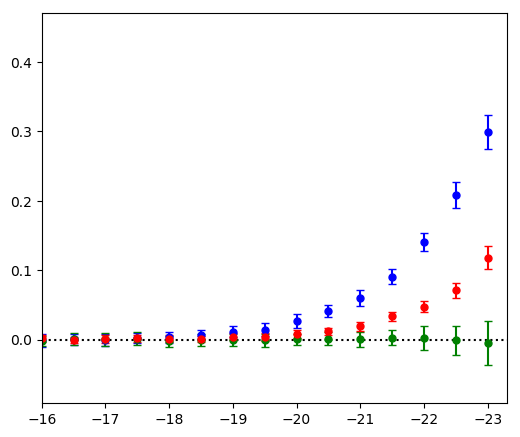

In [8]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)
ax.set_xlim(-16,-23.3)
ax.plot([-12,-24],[0,0], 'k:')

ax.errorbar(M0 , biasM, yerr=bias_errM, fmt='o', color='blue', capsize=3, markersize=5)
ax.errorbar(M0 , biasW, yerr=bias_errW, fmt='o', color='green', capsize=3, markersize=5)
ax.errorbar(M0 , biasMW, yerr=bias_errMW, fmt='o', color='red', capsize=3, markersize=5)

In [9]:
n_simul = 50
d_mag = 0.05
mag_scatter = 0.4



#########################################################

M0_C = np.arange(-16,-24,-0.5)
n_mag = len(M0_C)
outputs = np.zeros(n_mag*n_simul)
outputs = outputs.reshape(n_simul, n_mag)
for i in range(n_simul):
    bias, simulMag, simulWimx = simulFiled_Mscatter(slope, zp, Ms, alpha, 
               mag_scatter=mag_scatter, size=100000, seed=i)
    outputs[i] = simulCluster(M0_C, slope, zp, simulMag, simulWimx)
    if i%10==0:
        print i
bias_CM = np.median(outputs, 0)
bias_err_CM = np.std(outputs, 0)


#########################################################

M0_C = np.arange(-16,-24,-0.5)
n_mag = len(M0_C)
outputs = np.zeros(n_mag*n_simul)
outputs = outputs.reshape(n_simul, n_mag)
for i in range(n_simul):
    bias, simulMag, simulWimx = simulFiled_Wscatter(slope, zp, Ms, alpha, 
               mag_scatter=mag_scatter, size=100000, seed=i)
    outputs[i] = simulCluster(M0_C, slope, zp, simulMag, simulWimx)
    if i%10==0:
        print i
bias_CW = np.median(outputs, 0)
bias_err_CW = np.std(outputs, 0)

#########################################################

M0_C = np.arange(-16,-24,-0.5)
n_mag = len(M0_C)
outputs = np.zeros(n_mag*n_simul)
outputs = outputs.reshape(n_simul, n_mag)
for i in range(n_simul):
    bias, simulMag, simulWimx, real_mag, reallWimx  = simulFiled_MWscatter(slope, zp, Ms, alpha, 
               mag_scatter=mag_scatter, size=100000, seed=i)
    outputs[i] = simulCluster(M0_C, slope, zp, simulMag, reallWimx)
    if i%10==0:
        print i
bias_CMW = np.median(outputs, 0)
bias_err_CMW = np.std(outputs, 0)




0
10
20
30
40
0
10
20
30
40
0
10
20
30
40


<ErrorbarContainer object of 3 artists>

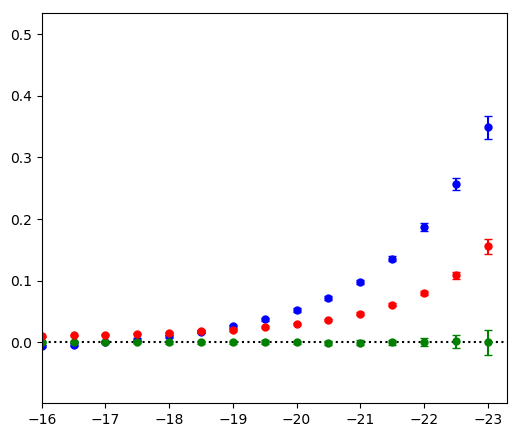

In [10]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)
ax.set_xlim(-16,-23.3)
ax.plot([-12,-24],[0,0], 'k:')

ax.errorbar(M0_C , bias_CM-bias_CM[2], yerr=bias_err_CM, fmt='o', color='blue', capsize=3, markersize=5)
ax.errorbar(M0_C , bias_CW, yerr=bias_err_CW, fmt='o', color='green', capsize=3, markersize=5)
ax.errorbar(M0_C , bias_CMW, yerr=bias_err_CMW, fmt='o', color='red', capsize=3, markersize=5)

In [11]:
n_simul = 100
d_mag = 0.05
mag_scatter = 0.4




M0 = np.arange(-16,-24,-0.5)
n_mag = len(M0)
outputs = np.zeros(n_mag*n_simul)
outputs = outputs.reshape(n_simul, n_mag)
for i in range(n_simul):
    outputs[i] = simulFiled_2(M0, slope, zp, Ms, alpha, mag_scatter=mag_scatter, 
                              d_mag=d_mag, seed=i, size=100000)
    if i%10==0:
        print i
bias = np.median(outputs, 0)
bias_err = np.std(outputs, 0)



for i in range(n_simul):
    outputs[i] = simulFiled_2(M0, slope, zp, Ms, alpha, mag_scatter=mag_scatter, 
                              d_mag=d_mag, seed=i, size=100000, dW=0.01)
    if i%10==0:
        print i
bias_A1 = np.median(outputs, 0)
bias_err_A1 = np.std(outputs, 0)


for i in range(n_simul):
    outputs[i] = simulFiled_2(M0, slope, zp, Ms, alpha, mag_scatter=mag_scatter, 
                              d_mag=d_mag, seed=i, size=100000, dW=0.03)
    if i%10==0:
        print i
bias_A3 = np.median(outputs, 0)
bias_err_A3 = np.std(outputs, 0)



for i in range(n_simul):
    outputs[i] = simulFiled_2(M0, slope, zp, Ms, alpha, mag_scatter=mag_scatter, 
                              d_mag=d_mag, seed=i, size=100000, dW=0.05)
    if i%10==0:
        print i
bias_A5 = np.median(outputs, 0)
bias_err_A5 = np.std(outputs, 0)



for i in range(n_simul):
    outputs[i] = simulFiled_2(M0, slope, zp, Ms, alpha, mag_scatter=mag_scatter, 
                              d_mag=d_mag, seed=i, size=100000, dW=0.07)
    if i%10==0:
        print i
bias_A7 = np.median(outputs, 0)
bias_err_A7 = np.std(outputs, 0)



for i in range(n_simul):
    outputs[i] = simulFiled_2(M0, slope, zp, Ms, alpha, mag_scatter=mag_scatter, 
                              d_mag=d_mag, seed=i, size=100000, dW=0.15)
    if i%10==0:
        print i
bias_A15 = np.median(outputs, 0)
bias_err_A15 = np.std(outputs, 0)



for i in range(n_simul):
    outputs[i] = simulFiled_2(M0, slope, zp, Ms, alpha, mag_scatter=mag_scatter, 
                              d_mag=d_mag, seed=i, size=100000, dW=0.1)
    if i%10==0:
        print i
bias_A10 = np.median(outputs, 0)
bias_err_A10 = np.std(outputs, 0)



for i in range(n_simul):
    outputs[i] = simulFiled_2(M0, slope, zp, Ms, alpha, mag_scatter=mag_scatter, 
                              d_mag=d_mag, seed=i, size=100000, dW=0.2)
    if i%10==0:
        print i
bias_A20 = np.median(outputs, 0)
bias_err_A20 = np.std(outputs, 0)


for i in range(n_simul):
    outputs[i] = simulFiled_2(M0, slope, zp, Ms, alpha, mag_scatter=mag_scatter, 
                              d_mag=d_mag, seed=i, size=100000, dW=0.5)
    if i%10==0:
        print i
bias_A50 = np.median(outputs, 0)
bias_err_A50 = np.std(outputs, 0)

#################################################################################


M0_C = np.arange(-16,-24,-0.5)
n_mag = len(M0_C)
outputs = np.zeros(n_mag*n_simul)
outputs = outputs.reshape(n_simul, n_mag)
for i in range(n_simul):
    outputs[i] = simulCluster(M0_C, slope, zp, Ms, alpha, mag_scatter=mag_scatter, seed=i, size=100000)
    if i%10==0:
        print i
bias_C = np.median(outputs, 0)
bias_err_C = np.std(outputs, 0)



NameError: name 'simulFiled_2' is not defined

In [ ]:
def biasFuc(M, a, b):
    
    return a*np.exp(b*(M+20))


def biasFuc2(M, a, b):
    
    return a*(np.abs(M+17))**b


def biasFuc3p(M, a, b,c ):
    x = np.abs(M+17)
    return a*x**3+b*x**2+c*x

def biasFuc2p(M, a, b):
    x = np.abs(M+17)
    return a*x**2+b*x


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)
ax.set_xlim(-16,-23.3)
ax.plot([-12,-24],[0,0], 'k:')



ax.plot(M0 , bias_A1,  'o', color='blue', markersize=5)
ax.plot(M0 , bias_A3,  'o', color='green', markersize=5)
ax.plot(M0 , bias_A5,  'o', color='red', markersize=5)
ax.plot(M0 , bias_A10,  'o', color='purple', markersize=5)
ax.plot(M0 , bias_A20,  'o', color='maroon', markersize=5)
# ax.plot(M0 , bias_A50,  'o', color='red', markersize=5)

ax.errorbar(M0 , bias_A50, yerr=bias_err_A50, fmt='o', color='black', capsize=3, markersize=5)
m = np.arange(-13,-23.3,-0.1)
fit, cov = curve_fit(biasFuc, M0, bias, sigma=bias_err)
print fit
print cov
ax.plot(m, biasFuc(m, fit[0], fit[1]), ':')

ax.errorbar(M0_C , bias_C-bias_C[0], yerr=bias_err_C, fmt='o', color='red', capsize=3, markersize=5)
# m = np.arange(-17,-24,-0.1)
# fit, cov = curve_fit(biasFuc2p, M0_C, bias_C-bias_C[0], sigma=bias_err_C)
# print fit
# print cov
# ax.plot(m, biasFuc2p(m, fit[0], fit[1]), ':')


m = np.arange(-17,-24,-0.1)
fit, cov = curve_fit(biasFuc3p, M0_C, bias_C-bias_C[0], sigma=bias_err_C)
print fit
print cov
ax.plot(m, biasFuc3p(m, fit[0], fit[1], fit[2]), ':', color='red')


# m = np.arange(-17,-24,-0.1)
# fit, cov = curve_fit(biasFuc2, M0_C, bias_C-bias_C[0], sigma=bias_err_C)
# print fit
# print cov
# ax.plot(m, biasFuc2(m, fit[0], fit[1]), ':', color='maroon')

In [ ]:
def horizLine(x, a):
    return x*0.+a

def fraction(ax, M0, bias_A1, bias_err_A1, bias, bias_err, color='blue'):
    
    frac = bias_A1/bias
    frac_err = bias*np.sqrt((bias_err_A1/bias_A1)**2+(bias_err/bias)**2)
    ax.errorbar(M0 , frac, yerr=frac_err,  fmt = 'o', color=color, markersize=5)
    
    indx,  = np.where(M0<-19)
    frac = frac[indx]
    frac_err = frac_err[indx]
    M0_ = M0[indx]
    fit, cov = curve_fit(horizLine, M0_, frac, sigma=frac_err)
    X = [-17,-23]
    ax.plot(X, [fit,fit],  'k:')
    return fit[0], np.sqrt(cov[0])[0]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)
ax.set_xlim(-16,-23.3)
ax.set_ylim(-0.5,1.5)


Y1, Y1_err = fraction(ax, M0, bias_A1, bias_err_A1, bias_A50, bias_err_A50, color='blue')
Y3, Y3_err = fraction(ax, M0, bias_A3, bias_err_A3, bias_A50, bias_err_A50, color='green')
Y5, Y5_err = fraction(ax, M0, bias_A5, bias_err_A5, bias_A50, bias_err_A50, color='red')
Y7, Y7_err = fraction(ax, M0, bias_A7, bias_err_A7, bias_A50, bias_err_A50, color='pink')
Y10, Y10_err = fraction(ax, M0, bias_A10, bias_err_A10, bias_A50, bias_err_A50, color='purple')
Y15, Y15_err = fraction(ax, M0, bias_A15, bias_err_A15, bias_A50, bias_err_A50, color='maroon')
Y20, Y20_err = fraction(ax, M0, bias_A20, bias_err_A20, bias_A50, bias_err_A50, color='black')



In [ ]:
def fitFunc(dW, a):
    return 1-a/(dW**2+a)

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


dW = np.asarray([0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2])
bW  = np.asarray([Y1, Y3, Y5, Y7, Y10, Y15, Y20])
bW_err  = np.asarray([Y1_err, Y3_err, Y5_err, Y7_err, Y10_err, Y15_err, Y20_err])

ax.errorbar(dW, bW, yerr=bW_err,  fmt = 'o', markersize=5)

dw_ = np.linspace(0,0.3,50)
fit, cov = curve_fit(fitFunc, dW, bW, sigma=bW_err)
print fit
print cov
ax.plot(dw_, fitFunc(dw_, fit[0]), ':', color='maroon')


print fitFunc(0.5, fit[0])

# ax.plot(dw_, fitFunc(dw_, 0.0018), ':', color='black')


In [ ]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

logWimx = table['logWimx']
logWimx_e = table['logWimx_e']

In [ ]:
plt.plot(logWimx, logWimx_e, '.', alpha=0.05)

In [ ]:
plt.hist(logWimx)

In [ ]:
plt.hist(logWimx, histtype='step', cumulative=1, density=True)

print len(logWimx[np.where(logWimx<2.05)])

In [ ]:
plt.hist(logWimx_e, bins=np.logspace(-3,0,30))
plt.yscale("log", nonposy='clip')
plt.xscale("log")

print np.logspace(-2,0,50)

In [ ]:
def Normal(x, mu, sigma):
    
    y = np.exp(-(x-mu)**2/(2.*sigma**2))
    
    return y/sigma/np.sqrt(2.*np.pi)

X = np.arange(-5,5,0.1)
plt.plot(X, Normal(X, 2, 1), 'r.')

In [ ]:
########################################################

def linfit(x, m, b):
    return m * x + b
def linfit_b(x, m):
    return m * x

## When the slope is fixed, 'b' the intercept is variable
def linfit_m(x, b):
    return x+b

########################################################
seed = 0 
size = 100000
np.random.seed(seed)

## TF realtion parameters
zp = -20.36
slope = -9.18

randMGAG = np.random.uniform(low=-25, high=-1, size=size*10)
randU = np.random.uniform(low=0, high=1, size=size*10)
randLfunct = LFfunction(randMGAG, Ms, alpha)
indx, = np.where(randU<randLfunct)
simulMag  = randMGAG[indx]
simulWimx = (simulMag-zp)/slope + 2.5


real_mag = simulMag[:size]
simulWimx = simulWimx[:size]


## scattring along the magnitude axis
N = len(real_mag)
scatterMAG = np.random.normal(0, 0.4, N)
simulMag = real_mag + scatterMAG


# plt.plot([1.5,3],[0,0], 'k:')
# plt.ylim(-12,-24)
for i, color in enumerate(['b', 'g', 'r']):    
    
    Mlim = -9 - 4*i
    
    indx, = np.where(simulMag<Mlim)
    simulMag_obs = simulMag[indx]
    simulWimx_obs = simulWimx[indx]
    simulMag_real =  slope*(simulWimx_obs-2.5)+zp
 
    
    fit, cov = curve_fit(linfit, simulMag_obs, simulWimx_obs-2.5)
    m, b = fit
    m0 = 1./m
    b0 = -b/m
    simulMag_pseudo =  m0*(simulWimx_obs-2.5)+b0
    print m0, b0
    bias = simulMag_real-simulMag_pseudo
    
    
    fit, cov = curve_fit(linfit, simulWimx_obs-2.5, simulMag_obs)
    m0_, b0_ = fit
    simulMag_pseudo_ =  m0_*(simulWimx_obs-2.5)+b0_
#     print m0_, b0_
    bias_ = simulMag_real-simulMag_pseudo_    
    
    
    w_ = np.linspace(1.6, 3 , 20)
    plt.plot(w_, (slope*(w_-2.5)+zp)- (m0*(w_-2.5)+b0), '-', color=color)
    plt.plot(w_, (slope*(w_-2.5)+zp)- (m0_*(w_-2.5)+b0_), '--', color=color)

    
#     W_min = (Mlim-zp)/slope + 2.5
#     print W_min
    
#     for W in np.arange(1.5,3.,0.1):
        
#         indx, = np.where(simulWimx_obs>W)
#         W_lst = simulWimx_obs[indx]
#         b_lst = bias[indx]
#         indx, = np.where(W_lst<W+0.1)
#         W_lst = W_lst[indx]
#         b_lst = b_lst[indx]
        
# #         print np.median(W_lst), np.median(b_lst)
#         plt.plot(np.median(W_lst), np.median(b_lst), '.', color=color)

# plt.plot(w_, slope*(w_-2.5)+zp, '-', color=color)

In [ ]:
def iterate(SZ, seed=0, 
               mag_scatter=0.56, Mlim = -17, along_MAG=True):
########################################################

    slope= SZ[0]; zp=SZ[1]
    
    size = 100000
    np.random.seed(seed)

    randMGAG = np.random.uniform(low=-25, high=-12, size=size*10)
    randU = np.random.uniform(low=0, high=1, size=size*10)
    randLfunct = LFfunction(randMGAG, Ms, alpha)
    indx, = np.where(randU<randLfunct)
    simulMag  = randMGAG[indx]
    simulWimx = (simulMag-zp)/slope + 2.5

    
    if along_MAG:
        real_mag = simulMag[:size]
        simulWimx = simulWimx[:size]
        ## scattring along the magnitude axis
        N = len(real_mag)
        scatterMAG = np.random.normal(0, mag_scatter, N)
        simulMag = real_mag + scatterMAG
    
    else:
        simulMag = simulMag[:size]
        reallWimx = simulWimx[:size]
        ## scattring along the magnitude axis
        N = len(simulMag)
        scatterW = np.random.normal(0, np.abs(mag_scatter/slope), N)
        simulWimx = reallWimx + scatterW    
    

    indx, = np.where(simulMag<Mlim)
    simulMag_obs = simulMag[indx]
    simulWimx_obs = simulWimx[indx]


    fit, cov = curve_fit(linfit, simulMag_obs, simulWimx_obs-2.5)
    m, b = fit
    m0 = 1./m
    b0 = -b/m
    
    return [m0, b0]

def Cost(SZ0, SZ):
    
    slope0 = SZ0[0]; zp0 = SZ0[1]
    slope  = SZ[0] ; zp  = SZ[1]
    return np.sqrt(((zp0-zp)/zp0)**2+((slope0-slope)/slope0)**2)


SZ0 = [-9.47, -20.43]
SZ1 = SZ0
SZ =  iterate(SZ1, along_MAG=True)
d = Cost(SZ0, SZ)

while d>0.0001:

    print SZ0, SZ1, Cost(SZ0, SZ), SZ

    d_dS =  (Cost(SZ0, iterate([SZ1[0]+0.01, SZ1[1]]))-Cost(SZ0, iterate([SZ1[0]-0.01, SZ1[1]])))/0.02
    d_dz =  (Cost(SZ0, iterate([SZ1[0], SZ1[1]+0.05]))-Cost(SZ0, iterate([SZ1[0], SZ1[1]-0.05])))/0.01

    SZ1 = [SZ1[0] - 0.1*d_dS, SZ1[1] - 0.1*d_dz]
    SZ =  iterate(SZ1, along_MAG=True)
    d = Cost(SZ0, SZ)

    
print SZ0, SZ1, Cost(SZ0, SZ), SZ
